# Access to Parks and Fitness Facilities in Manhattan

## Introduction

According to a [study](https://www.mayoclinicproceedings.org/article/S0025-6196(16)00043-4/abstract) published in *Mayo Clinic Proceedings*, less than 3% of Americans live a healthy lifestyle. One of the key factors characterizing a healthy lifestyle is exercise, but many Americans lack easy access to parks and fitness facilities. Among the 100 largest metro areas in the US, only [54% of people live less than half a mile from a park](https://www.brookings.edu/blog/the-avenue/2019/08/21/parks-make-great-places-but-not-enough-americans-can-reach-them/).

In this notebook, this issue is explored by investigating the access to sports and fitness facilities across different neighborhoods in Manhattan. The Foursquare API is used to collect data on the number of parks, gyms, sports facilities such as basketball and tennis courts, and fitness classes in a given area. Using this data, the neighborhoods are grouped into clusters. The demographics of each cluster are then compared to explore the relationship between factors such as income and access to green spaces and fitness facilities.

This type of analysis could be used to identify city areas with inequitable access to parks and fitness facilities, and may be used to help city planners address these gaps.

## Table of Contents
* [1. Building the Dataset](#first-bullet)
* [2. Cleaning the Data](#second-bullet)
* [3. Clustering Neighborhoods](#third-bullet)
* [4. Examining the Clusters](#fourth-bullet)
* [5. Conclusions and Recommendations](#fifth-bullet)

### Importing the required libraries

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests

from geopy import Nominatim # library to convert an address into latitude and longitude values

import folium # map rendering library

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer # library to find the elbow point for k-means clustering

print('Libraries imported.')

Libraries imported.


C:\Users\racin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## 1. Building the Dataset <a class="anchor" id="first-bullet"></a>

In order explore access to green spaces and fitness facilities and its relationship to demographic factors, the following datasets are needed:
1. Demographic data by neighborhood
2. Longitude and latitude points respresenting each neighborhood
3. A list of nearby parks and sports/fitness facilities for each neighborhood
4. GeoJSON file of Neighborhood Tabulation Areas (for visualization)

Datasets #1 and #2 were found in the notebook titled [Manhattan-neighborhood-data](https://github.com/racinenassau/mahattan-park-and-fitness-access/blob/master/Manhattan-neighborhood-data.ipynb). This notebook imports NYC census data, which is reported according to Census Tract rather than neighborhood. Each neighborhood consists of multiple census tracts, so these census tracts were converted to their respective neighborhoods and the overall demographics of each neighborhood were calculated. This notebook also calculates the latitude and longitude coordinates of each neighborhood. Please refer to this notebook for a detailed explanation of how these datasets were built.

Dataset #3 is built using Foursquare location data. The Foursquare API is used to find parks, gyms, sports facilities, and fitness classes within 500 meters of the geographical coordinates representing each neighborhood. Rather than comparing the number of these "venues" in each neighborhood, it seemed more meaningful to explore how many venues a resident of a particular neighborhood could walk to within 500 m, making it easier to compare across neighborhoods of different sizes.

Dataset #4 was downloaded from the [NYC Department of City Planning website](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-nynta.page), and provides the Neighborhood Tabulation Areas (NTAs) for NYC neighborhoods.

### Demographic data by neighborhood

The dataset resulting from the [Manhattan-neighborhood-data](https://github.com/racinenassau/mahattan-park-and-fitness-access/blob/master/Manhattan-neighborhood-data.ipynb) notebook is imported, giving us the following data for each neighborhood:
* Latitude and longitude
* Area
* Total population
* Population density
* Population breakdown by gender
* Population breakdown by race
* Median income
* Percent living in poverty
* Percent walking to work
* Mean commute time
* Unemployment rate

In [3]:
manhattan_data = pd.read_csv('manhattan-neighborhood-data.csv')

manhattan_data.head()

,Unnamed: 0,Neighborhood,Latitude,Longitude,Area,TotalPop,Population Density,Men,Women,Hispanic,White,Black,Asian,Income,Poverty,Walk,MeanCommute,Unemployment
0,0,Clinton,40.764175,-73.992395,7.092697,43450,6126.019376,54.69,45.31,21.22,55.45,5.52,14.90,79494.05,12.58,36.24,27.45,6.72
1,1,Battery Park City-Lower Manhattan,40.708547,-74.010916,7.344586,44436,6050.170905,48.55,51.45,8.66,65.33,2.68,20.43,135072.58,7.38,29.12,25.26,3.75
2,2,Lincoln Square,40.774855,-73.984701,6.105156,59921,9814.818141,46.72,53.28,9.51,74.22,2.72,10.68,122296.16,8.08,18.44,28.38,4.82
3,3,Midtown-Midtown South,40.755742,-73.983504,11.662014,28080,2407.817386,48.28,51.72,7.53,65.05,3.74,20.95,125437.65,13.86,42.67,22.89,5.38
4,4,Upper East Side-Carnegie Hill,40.774738,-73.961176,7.750593,58161,7504.070522,44.65,55.35,6.10,84.70,1.07,5.77,164660.74,5.16,18.37,27.09,3.76


### GeoJSON data

As detailed in the notebook titled [Manhattan-neighborhood-data](https://github.com/racinenassau/mahattan-park-and-fitness-access/blob/master/Manhattan-neighborhood-data.ipynb), we load the GeoJSON file for the tabulated NYC neighborhoods and extract only the relevant Manhattan neighborhoods.

In [4]:
# Load geojson features of all neighborhoods in NYC
manhattan_geo = json.load(open("nyc-neighborhood-tabulation-areas.geojson"))

# Extract only the Manhattan features
borough_name = "Manhattan"

manhattan_geo['features'] = [nbh for nbh in manhattan_geo['features'] if nbh['properties']['BoroName'] == borough_name]

# Drop feature named "park-cemetery-etc-Manhattan"
manhattan_geo['features'] = [nbh for nbh in manhattan_geo['features'] if nbh['properties']['NTAName'] != 'park-cemetery-etc-Manhattan']

### Foursquare Location Data

We will use the Foursquare API to find park and sports/fitness facilities in each neighborhood. Let's start by defining the Foursquare credentials. You will have to enter your own [Foursquare ID and Foursquare secret](https://developer.foursquare.com/) below.

In [32]:
CLIENT_ID = 'your-foursquare-id' # Foursquare ID
CLIENT_SECRET = 'your-foursquare-secret' # Foursquare Secret

VERSION = '20200801' # Foursquare API version
LIMIT = 100

Here is a function to find venues of the specified category within a certain radius of the provided geographical coordinates.

In [6]:
def get_neighborhood_venues(neighborhoods, latitudes, longitudes, category, radius=500):
    # Initialize a list of venues
    venues_list = []
    
    # Loop through each neighborhood
    for nbh, lat, lng in zip(neighborhoods, latitudes, longitudes):
        # Create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            category, 
            radius, 
            LIMIT)
            
        # Send the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # Return only the name, location, and category of each nearby venue
        venues_list.append([(
            nbh, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    # Structure the venue data into a dataframe
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue Name', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Using the above function, we are now ready to collect location data from Foursquare. Looking at Foursquare's [Venue Categories](https://developer.foursquare.com/docs/build-with-foursquare/categories/), there are two main categories of interest. The first one is the *Athletics & Sports* category, which refers to venues such as gyms, basketball courts, soccer fields, yoga studios, and other fitness classes. The second category is the *Park* category. Let's define these category ID's below.

In [7]:
# Foursquare categories of interest
athletics_and_sports_category = '4f4528bc4b90abdf24c9de85'
park_category = '4bf58dd8d48988d163941735'

Now we're ready to use the *get_neighborhood_venues* to find venues in each of the above categories in each neighborhood.

In [9]:
# Find Foursquare venues in each neighborhood matching the Athletics & Sports category
athletics_venues = get_neighborhood_venues(neighborhoods=manhattan_data['Neighborhood'],
                                           latitudes=manhattan_data['Latitude'],
                                           longitudes=manhattan_data['Longitude'],
                                           category=athletics_and_sports_category)

In [10]:
# Find Foursquare venues in each neighborhood matching the Park category
park_venues = get_neighborhood_venues(neighborhoods=manhattan_data['Neighborhood'],
                                           latitudes=manhattan_data['Latitude'],
                                           longitudes=manhattan_data['Longitude'],
                                           category=park_category)

## 2. Cleaning the Data <a class="anchor" id="second-bullet"></a>

We have now collected all the data needed to proceed, but the Foursquare location data still needs to be cleaned. Let's start by checking the category labels for the venues found. Each venue category has many sub-categories, and some may be irrelevant to our search.

In [11]:
# List the unique venue category labels found in the Sports & Athletics category
athletics_venues['Venue Category'].unique()

array(['Athletics & Sports', 'Gym / Fitness Center', 'Gym',
       'Basketball Court', 'Yoga Studio', 'Religious School',
       'Pilates Studio', 'Health & Beauty Service', 'Cycle Studio',
       "Doctor's Office", 'Weight Loss Center', 'Event Space', 'Office',
       'College Gym', 'Physical Therapist',
       'Residential Building (Apartment / Condo)', 'High School',
       'Medical Center', 'Martial Arts School', 'Baseball Field',
       'Gym Pool', 'Sporting Goods Shop', 'Massage Studio',
       'Chiropractor', 'Construction & Landscaping', 'Hospital',
       'Soccer Field', 'Tennis Court', 'Spa', 'General Entertainment',
       'Skating Rink', 'Playground', 'Skate Park', 'Event Service',
       'Golf Course', 'Gymnastics Gym', 'Paintball Field', 'Boxing Gym',
       'Park', 'Sports Club', 'Asian Restaurant', 'Moving Target',
       'Building', 'Track', 'Nutritionist', 'Climbing Gym', 'Club House',
       'Non-Profit', 'Dance Studio', 'Golf Driving Range', 'Outdoor Gym',
       'P

In [12]:
# List the unique venue category labels found in the Sports & Athletics category
park_venues['Venue Category'].unique()

array(['Park', 'Dog Run', 'Playground', 'Trail', 'Memorial Site',
       'Garden', 'Historic Site', 'Other Great Outdoors',
       'Monument / Landmark', 'Plaza', 'Outdoor Sculpture',
       'Neighborhood', 'Road', 'Library', 'Athletics & Sports',
       'Fountain', 'General Travel', 'Field', 'Housing Development',
       'Butcher', 'Basketball Court', 'Motel', 'General Entertainment',
       'Intersection', 'Tennis Court', 'Soccer Field', 'Scenic Lookout'],
      dtype=object)

Many of these labels, such as "Asian Restaurant" and "Sporting Goods Shops," are not the types of venues we were looking for. Others such as "Gym" and "Gym/Fitness Center" can be consolidated into the same category. Let's make a list of all the venue category labels that we would like to exclude from our anlysis.

In [13]:
del_labels = ['Religious School', 'Health & Beauty Service', "Doctor's Office", 'Weight Loss Center',
              'Event Space', 'Office', 'Physical Therapist', 'Residential Building (Apartment / Condo)', 
              'High School', 'Medical Center', 'Sporting Goods Shop', 'Massage Studio', 'Chiropractor', 
              'Construction & Landscaping', 'Hospital', 'Spa', 'General Entertainment', 'Event Service', 
              'Paintball Field', 'Asian Restaurant', 'Moving Target', 'Building', 'Nutritionist', 
              'Climbing Gym', 'Club House', 'Non-Profit', "Women's Store", 'Hotel', 'Indie Movie Theater',
              'Road', 'Library', 'General Travel', 'Butcher', 'Motel', 'Intersection', 'Neighborhood']

To make our analysis easier, let's consolidate the category labels into four different categories.
* Parks (includes parks, gardens, trails, and playgrounds(
* Gyms (includes different types of gyms)
* Sports (includes different types of sports fields and facilities, such as basketball courts and soccer fields)
* Fitness Classes (includes yoga studios, martial arts schools, and pilates studios)

We create four different lists below, each containing the relevant category labels.

In [14]:
park_label = ['Park', 'Dog Run', 'Playground', 'Trail', 'Memorial Site', 
              'Garden', 'Historic Site', 'Other Great Outdoors', 
              'Monument / Landmark', 'Plaza', 'Outdoor Sculpture', 'Fountain', 
              'Field', 'Housing Development', 'Scenic Lookout', 'Outdoor Gym']

gym_label = ['Gym', 'Gym / Fitness Center', 'College Gym', 
             'Climbing Gym', 'Sports Club', 'Gym Pool']

sports_label = ['Athletics & Sports', 'Basketball Court', 'Baseball Field', 
                'Soccer Field', 'Tennis Court', 'Skating Rink', 'Skate Park',
                'Golf Course', 'Track', 'Golf Driving Range', 'Squash Court', 
                'Pool', 'Community Center']

fitness_class_label = ['Yoga Studio', 'Pilates Studio', 'Cycle Studio', 
                       'Martial Arts School', 'Gymnastics Gym', 'Boxing Gym', 
                       'Dance Studio']

We can now add each element in the above lists to a dictionary containing the category names they should be replaced with.

In [15]:
# Make a dictionary of category labels along with the names to replace them with
category_dict = dict()

# Add categories to delete
for label in del_labels:
    category_dict[label] = None

# Add park labels
for label in park_label:
    category_dict[label] = 'Park'
    
# Add gym labels
for label in gym_label:
    category_dict[label] = 'Gym'

# Add sports labels
for label in sports_label:
    category_dict[label] = 'Sports Facility'

# Add fitness class labels
for label in fitness_class_label:
    category_dict[label] = 'Fitness Class'

Some of the same venues show up in both the *Athletics & Sports* search and the *Park* search. Let's get rid of any duplicate entries.

In [16]:
# Combine the athletics and park venues into one dataframe
nbh_venues = pd.concat([athletics_venues, park_venues])

# Drop duplicate venues
nbh_venues = nbh_venues.drop_duplicates()

Now we can replace the category labels using the *category_dict* dictionary .

In [17]:
# Replace the venue categories with their respective cleaned label
nbh_venues['Venue Category'] = nbh_venues['Venue Category'].replace(category_dict)

# Drop venue categories labeled None
nbh_venues = nbh_venues.dropna()

# Display the results
nbh_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Clinton,40.764175,-73.992395,Big City Volleyball,40.767588,-73.988736,Sports Facility
1,Clinton,40.764175,-73.992395,Mercedes Club,40.767595,-73.992070,Gym
2,Clinton,40.764175,-73.992395,TMPL,40.762550,-73.988177,Gym
3,Clinton,40.764175,-73.992395,Ogilvy Fitness,40.763461,-73.996291,Gym
4,Clinton,40.764175,-73.992395,Bounce And Flip,40.765986,-73.990541,Sports Facility


### Analyze sports & rec availability by neighborhood

In order to compare different neighborhoods, let's compare the number of venues of each category in each neighborhood. We can use *one hot encoding* to represent the categories.

In [18]:
mht_onehot = pd.get_dummies(nbh_venues[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column to this dataframe
mht_onehot.insert(loc=0, column='Neighborhood', value=nbh_venues['Neighborhood'])

mht_onehot.head()

,Neighborhood,Fitness Class,Gym,Park,Sports Facility
0,Clinton,0,0,0,1
1,Clinton,0,1,0,0
2,Clinton,0,1,0,0
3,Clinton,0,1,0,0
4,Clinton,0,0,0,1


Let's group the neighborhoods by row, counting the number of facilities in each category.

In [19]:
# Group neighborhoods
mht_grouped = mht_onehot.groupby('Neighborhood').sum().reset_index()

# Display the data
mht_grouped.head()

,Neighborhood,Fitness Class,Gym,Park,Sports Facility
0,Battery Park City-Lower Manhattan,2,92,29,2
1,Central Harlem North-Polo Grounds,2,9,3,6
2,Central Harlem South,6,9,3,5
3,Chinatown,5,14,15,12
4,Clinton,3,25,12,5


We now have the number of park, gym, fitness class, and sports facility venues in each neighborhood and are ready to analyze the data.

## 3. Methodology: Clustering Neighborhoods <a class="anchor" id="third-bullet"></a>

In order to understand which neighborhoods are most similar in terms of access to gyms, parks, sports facilities, and fitness classes, we can group the neighborhoods into clusters. We can use k-means clustering to perform the clustering.

### Perform k-means Clustering Using the Elbow Method

Since the appropriate number of clusters to represent this data is still unknown, let's use the elbow method, running k-means over a range of different numbers of clusters.

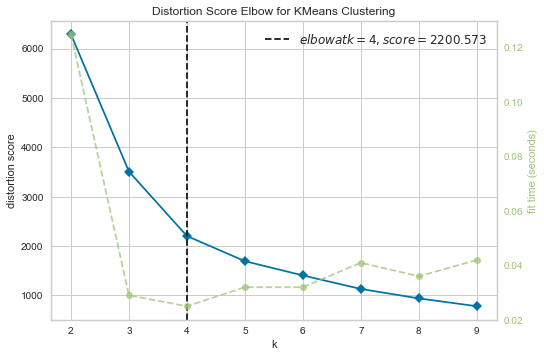

In [20]:
# Create a dataframe consisting of the data that will be used for clustering
clustering_data = mht_grouped[['Fitness Class', 'Gym', 'Park', 'Sports Facility']]
#clustering_data = mht_grouped_merged[['Sports and Fitness Facilities', 'Population Density']]

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10)) # Runs over 2-9 clusters

visualizer.fit(clustering_data)   # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

As shown in the plot above, the optimal number of clusters is four. Let's perform k-means clustering using four clusters and examine our results.

In [21]:
# Set the number of clusters
kclusters = 4

# Run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(clustering_data)

# Check cluster labels
kmeans.labels_[0:10]

array([2, 1, 1, 1, 0, 1, 1, 0, 0, 1])

In [22]:
# Add cluster labels to the dataset used for clustering
mht_grouped['Cluster Label'] = kmeans.labels_

Now let's merge the cluster labels with the demographics data for each neighborhood.

In [25]:
# Merge the clustering data with the demographics data
manhattan_data_labeled = pd.merge(mht_grouped[['Neighborhood', 'Cluster Label']], manhattan_data, on='Neighborhood')

manhattan_data_labeled.head()

,Neighborhood,Cluster Label,Unnamed: 0,Latitude,Longitude,Area,TotalPop,Population Density,Men,Women,Hispanic,White,Black,Asian,Income,Poverty,Walk,MeanCommute,Unemployment
0,Battery Park City-Lower Manhattan,2,1,40.708547,-74.010916,7.344586,44436,6050.170905,48.55,51.45,8.66,65.33,2.68,20.43,135072.58,7.38,29.12,25.26,3.75
1,Central Harlem North-Polo Grounds,1,5,40.818265,-73.940773,9.812537,82898,8448.172370,46.70,53.30,24.49,8.68,61.55,2.14,35470.52,29.08,8.95,37.23,15.99
2,Central Harlem South,1,15,40.804341,-73.951295,5.577412,48993,8784.181775,46.10,53.90,20.19,19.31,53.06,4.82,48798.28,27.55,7.19,34.50,8.26
3,Chinatown,1,25,40.715615,-73.994631,5.601614,45325,8091.418358,51.48,48.52,13.50,17.22,4.82,59.84,38425.29,28.91,30.70,31.00,8.22
4,Clinton,0,0,40.764175,-73.992395,7.092697,43450,6126.019376,54.69,45.31,21.22,55.45,5.52,14.90,79494.05,12.58,36.24,27.45,6.72


### Visualization

We can visualize these clusters on a map of Manhattan using the Folium library. We can also add layers on this map for different demographic features to compare how our clusters overlap with different demographic data. Let's visualize the following demographic features on our map:
* Population density
* Income
* Poverty rates
* Commute time (neighborhoods where residents have a short commute time may have more office buildings and businesses)

In [26]:
# Get the latitude and longitude of Manhattan (for us to use when we create our map)
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="nyc_explorer")
location = geolocator.geocode(address)
mht_latitude = location.latitude
mht_longitude = location.longitude

In [27]:
# Create a map of Manhattan using its geographical coordinates
map_nyc = folium.Map(location=[mht_latitude, mht_longitude], zoom_start=11)

# Define a function to add a map layer for the specified feature of the neighborhood data
def add_map_layer(df, column_name, title, color):
    # Add the color for the chloropleth:
    choropleth = folium.Choropleth(
        geo_data=manhattan_geo,
        data=df,
        columns=['Neighborhood', column_name],
        key_on='feature.properties.NTAName',
        fill_color=color,
        name=title,
        show=False,
    ).add_to(map_nyc)

# Add chloropleth layers for different features
add_map_layer(manhattan_data, 'Population Density', 'Population Density', 'YlGn')
add_map_layer(manhattan_data, 'Income', 'Income', 'Blues')
add_map_layer(manhattan_data, 'Poverty', 'Poverty (%)', 'PuRd')
add_map_layer(manhattan_data, 'MeanCommute', 'Commute Time (min)', 'Reds')

folium.LayerControl(collapsed=False).add_to(map_nyc)

# Set color scheme for the clusters (purple, orange, green, blue)
rainbow = ['#cc33ff', '#ff6633', '#33ff66', '#33ccff']

# Add markers for each neighborhood to the map
for lat, lng, nbh, cluster in zip(manhattan_data_labeled['Latitude'], 
                                    manhattan_data_labeled['Longitude'], 
                                    manhattan_data_labeled['Neighborhood'], 
                                    manhattan_data_labeled['Cluster Label']):
    label = folium.Popup(str(nbh) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7,
        parse_html=False).add_to(map_nyc)

# Display the map
map_nyc

In the map above, we can visualize different demographic features on top of our clusters by clicking on the check boxes on the right hand side. At first glance, it seems that the orange cluster falls in the neighborhoods with the highest poverty rates and lowest income.

## 4. Discussion: Examining the Clusters <a class="anchor" id="fourth-bullet"></a>

We can now examine what defines the different clusters. Let's start off by grouping the neighborhoods by cluster, averaging over each feature. Let's extract some features of interest and replace the cluster labels by the colors used to represent them in the above map.

In [28]:
# Merge the venue data with the neighborhood data
cluster_results = pd.merge(mht_grouped, manhattan_data, on='Neighborhood')

# Group the neighborhoods by cluster, averaging over each feature
cluster_results_grouped = cluster_results.iloc[:, 1:].groupby('Cluster Label').mean().reset_index()

# Round the values to two decimal places
cluster_results_grouped = cluster_results_grouped.round(2)

In [29]:
# Extract features of interest
cluster_means = cluster_results_grouped[['Cluster Label', 
                                         'Fitness Class', 
                                         'Gym', 
                                         'Park', 
                                         'Sports Facility', 
                                         'Population Density', 
                                         'Income', 
                                         'Poverty']]

In [30]:
# Sort the clusters by income
cluster_means = cluster_means.sort_values(by=['Income'])

# Replace the cluster labels (0, 1, 2, 3) with the colors used to represent them (purple, orange, green, blue)
cluster_means['Cluster Label'] = cluster_means['Cluster Label'].replace([0, 1, 2, 3], ['Purple', 'Orange', 'Green', 'Blue'])

In [31]:
# Display the resulting dataframe
cluster_means

,Cluster Label,Fitness Class,Gym,Park,Sports Facility,Population Density,Income,Poverty
1,Orange,2.62,5.85,6.62,6.00,8201.61,45241.10,27.27
0,Purple,8.55,26.36,9.45,7.55,9049.67,106226.70,9.85
3,Blue,18.00,57.00,15.00,10.00,4727.25,107442.45,9.72
2,Green,2.00,92.00,29.00,2.00,6050.17,135072.58,7.38


In the table above, we can examine the average number of sports/fitness venues for each category. Using this information, we can characterize the access to sports/fitness facilities in each cluster. We can also see how this type of access is correlated to demographic and economic data.

### Orange Cluster

The neighborhoods in the orange cluster are characterized by low numbers of parks, gyms, sports facilities such as basketball courts, and fitness classes. The people living in these neighborhoods have low access to both public and private sports/fitness facilities, despite living in areas of relatively high population density. The orange cluster is characterized by far lower income than the other clusters, along with far significantly higher poverty rates. This data suggests that Manhattan's poorest residents not only lack access to paid private fitness facilities such as gyms, but also to free public fitness/recreation areas such as parks and sports fields. 

Geographically, two areas of the city make up the orange cluster. Every neighborhood in northern Manhattan falls into the orange cluster. The remaining three neighborhoods are clustered around the Lower East Side.

### Purple Cluster

The purple cluster has more sports/fitness facilities in every category than the orange cluster. However, the difference is especially great in the fitness class and gym categories. With income levels more than twice as high and poverty rates roughly one third those of the orange cluster, the residents of the purple cluster may have more discretionary income to spend on fitness related services such as gyms and yoga classes.

### Blue Cluster

The neighborhoods in the blue cluster tend to be high income and have very high numbers of parks, gyms, sports facilities, and fitness classes. Although the population density of this cluster is significantly lower than the others, the residents of these neighborhoods enjoy high access to a variety of public and private sports/fitness facilities.

### Green Cluster

The green cluster consists of only one neighborhood, Battery Park City-Lower Manhattan. What sets this neighborhood apart from the others is that it has more gyms and parks than any other neighborhood, despite relatively low numbers of fitness classes and sports facilities such as basketball/tennis courts. This neighborhood is characterized by very high income compared to the other neighborhoods.

## 5. Conclusions and Recommendations <a class="anchor" id="fifth-bullet"></a>


The neighborhoods with low income and high poverty rates have relatively low access to both public and private public fitness/recreation areas. The data analyzed suggests that Manhattan's parks and public sports facilities are not distributed according to population density, but rather are more heavily concentrated in areas of higher income. If Manhattan has future resources to invest in new public parks and sports facilities, it may be more equitable to invest more heavily in the orange cluster neighborhoods.